In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
from catboost import CatBoostRegressor

import time
import warnings
from tqdm.notebook import tqdm

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

# Hardcode NAN encoding where appropriate

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')

In [4]:
def _patch_ct(ct: ColumnTransformer):
    try:
        params = ct.get_params(deep=False)
        if "force_int_remainder_cols" in params:
            val = params["force_int_remainder_cols"]
            if val == "deprecated" or not isinstance(val, (bool,)):
                ct.set_params(force_int_remainder_cols=False)
    except Exception:
        if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
            del ct.__dict__["force_int_remainder_cols"]

def patch_sklearn_objects(obj):
    if isinstance(obj, ColumnTransformer):
        _patch_ct(obj)
        for _, trans, _ in getattr(obj, "transformers", []):
            if isinstance(trans, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(trans)
        return obj

    if isinstance(obj, Pipeline):
        for _, step in obj.steps:
            if isinstance(step, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(step)
        return obj

    for attr in ("named_steps", "_final_estimator"):
        if hasattr(obj, attr):
            sub = getattr(obj, attr)
            try:
                patch_sklearn_objects(sub)
            except Exception:
                pass
    return obj

In [46]:
X_fe = Ames.copy()

# Targeted Feature Engineering
X_fe["TotalSF"] = X_fe["GrLivArea"] + X_fe["TotalBsmtSF"]
X_fe["HouseAgeSinceRemod"] = X_fe["YrSold"].astype(int) - X_fe["YearRemodAdd"].astype(int)
X_fe['TotalBaths'] = X_fe['FullBath'] + 0.4 * X_fe['HalfBath'] + 1.2 * X_fe['BsmtFullBath'] + 0.2 * X_fe['BsmtHalfBath']


# Add Interactions
X_fe['TotalSF_x_Qual'] = X_fe['TotalSF'] * X_fe['OverallQual']

X_fe = X_fe.drop(columns=['SalePrice','PID','YearBuilt'])
y = Ames['SalePrice']

In [6]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF","GrLivArea_per_LotArea",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAge","HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre



def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])


# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: list[tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,
    show_progress: bool = True,
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    # Outer loop: models (optional outer bar)
    model_iter = models if not show_progress else tqdm(models, desc="Models", leave=True)

    for name, est in model_iter:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        # Inner loop: folds (progress bar per model)
        fold_iter = range(cv) if not show_progress else tqdm(range(cv), desc=f"{name} folds", leave=False)

        for i, (tr, va) in zip(fold_iter, kf.split(X)):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(float(np.sqrt(((y_va - pred) ** 2).mean())))
            oof[va] = pred

        # full fit
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [7]:
from sklearn.ensemble import RandomForestRegressor

def make_rf_pipe(
    df_schema: pd.DataFrame,
    *,
    rf_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    rf_kwargs = rf_kwargs or {"n_estimators": 600, "random_state": 42, "n_jobs": -1}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[], zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", RandomForestRegressor(**rf_kwargs))])

In [14]:
warnings.filterwarnings("ignore")
models = [
    ("Ridge",       make_linear_pipe(X_fe, model="ridge",  model_kwargs={"alpha":50.0})),
    ("Lasso",       make_linear_pipe(X_fe, model="lasso",  model_kwargs={"alpha":0.001})),
    ("ElasticNet",  make_linear_pipe(X_fe, model="enet",   model_kwargs={"alpha":0.05, "l1_ratio":0.5})),
    ("HistGB",      make_histgb_pipe(X_fe, hgb_kwargs={"learning_rate":0.08, "max_leaf_nodes":31,
                                                       "min_samples_leaf":20, "random_state":42})),
    ("RandomForest",make_rf_pipe(X_fe, rf_kwargs={"n_estimators":600, "max_depth":None,
                                                  "min_samples_leaf":1, "random_state":42, "n_jobs":-1})),
    # ↓ remove random_seed to avoid clash with default random_state in make_catboost_pipe
    ("CatBoost",    make_catboost_pipe(X_fe, depth=8, learning_rate=0.05,
                                       l2_leaf_reg=3.0, iterations=1200, loss_function="RMSE",
                                       verbose=0)),  # random_state=42 is set inside the maker
]



leaderboard = cv_eval_models(X_fe, y, models, cv=5, log_target=True, random_state=42)
leaderboard

Models:   0%|          | 0/6 [00:00<?, ?it/s]

Ridge folds:   0%|          | 0/5 [00:00<?, ?it/s]

Lasso folds:   0%|          | 0/5 [00:00<?, ?it/s]

ElasticNet folds:   0%|          | 0/5 [00:00<?, ?it/s]

HistGB folds:   0%|          | 0/5 [00:00<?, ?it/s]

RandomForest folds:   0%|          | 0/5 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,CatBoost,19919.363633,2639.280564,0.928254,0.997781
1,Ridge,21698.015260,4333.621219,0.913001,0.933312
2,HistGB,22017.466224,3303.436649,0.911918,0.980334
3,Lasso,23048.429537,5142.897199,0.900901,0.922936
4,RandomForest,24493.614466,3805.550498,0.890818,0.986077
5,ElasticNet,27593.944904,3935.917524,0.861942,0.872540


In [15]:
best_df = variants[ablation.iloc[0]["variant"]]   # choose the winning variant
final_pipe = cat_pipe_for(best_df)
final_pipe.fit(best_df, np.log1p(y))              # log target to match evaluator
# back-transform only when predicting, not needed for importances

feat_names = final_pipe.named_steps["prep"].get_feature_names_out()
importances = final_pipe.named_steps["reg"].get_feature_importance()

imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
         .sort_values("importance", ascending=False)
         .reset_index(drop=True))
imp.head(20)

,feature,importance
0,TotalSF_x_Qual,28.221094
1,TotalSF,6.574034
2,OverallCond,3.464670
3,OverallQual,3.323448
4,HouseAgeSinceRemod,3.133656
5,TotalBaths,3.119479
6,LotArea,2.889748
7,GarageCars,2.385915
8,GarageYrBlt,2.354373
9,GrLivArea,2.325904


In [17]:
# --- Define the CatBoost pipeline (reuse your helper) ---
def cat_pipe_for(df_schema):
    return make_catboost_pipe(
        df_schema,
        depth=8, learning_rate=0.05,
        l2_leaf_reg=3.0, iterations=1200,
        loss_function="RMSE", verbose=0
    )

def eval_one(Xmat, label="CatBoost"):
    return cv_eval_models(
        Xmat, y,
        [(label, cat_pipe_for(Xmat))],
        cv=5, log_target=True, random_state=42
    )

# --- Features to test (engineered ones you might want to drop) ---
eng_feats_to_test = [
    "TotalSF",
    "HouseAgeSinceRemod",
    # (TotalBaths and TotalSF_x_Qual are excluded — we already know they're good)
]

# --- Build variants (baseline = all engineered features) ---
variants = {"All_features": X_fe.copy()}

for f in eng_feats_to_test:
    if f in X_fe.columns:
        cols = [c for c in X_fe.columns if c != f]
        variants[f"Dropped_{f}"] = X_fe[cols]

# --- Run evaluation ---
ablation_rows = []
for name, Xv in variants.items():
    res = eval_one(Xv, label="CatBoost")
    row = res.iloc[0].to_dict()
    row["variant"] = name
    ablation_rows.append(row)

ablation = (
    pd.DataFrame(ablation_rows)
      .sort_values("cv_rmse_mean")
      .reset_index(drop=True)
)

ablation[["variant","cv_rmse_mean","cv_rmse_std","r2_cv","r2_full"]]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,variant,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,All_features,19919.363633,2639.280564,0.928254,0.997781
1,Dropped_TotalSF,19986.993061,2815.164561,0.927604,0.997802
2,Dropped_HouseAgeSinceRemod,20145.413686,2787.515940,0.926502,0.997842


In [18]:
import itertools
import pandas as pd

# Reuse your helpers
def cat_pipe_for(df_schema):
    return make_catboost_pipe(
        df_schema,
        depth=8, learning_rate=0.05,
        l2_leaf_reg=3.0, iterations=1200,
        loss_function="RMSE", verbose=0
    )

def eval_one(Xmat, label="CatBoost"):
    return cv_eval_models(
        Xmat, y,
        [(label, cat_pipe_for(Xmat))],
        cv=5, log_target=True, random_state=42
    )

# Engineered features worth testing for redundancy in pairs
pair_pool = [
    "TotalSF",
    "HouseAgeSinceRemod",
    # Intentionally NOT including "TotalBaths" and "TotalSF_x_Qual" — we keep those.
]

# Baseline row (all features kept)
rows = []
base_res = eval_one(X_fe, label="CatBoost")
base_row = base_res.iloc[0].to_dict()
base_row["drop_set"] = "None (All_features)"
rows.append(base_row)

# --- Pairwise drops ---
for f1, f2 in itertools.combinations(pair_pool, 2):
    cols = [c for c in X_fe.columns if c not in (f1, f2)]
    Xv = X_fe[cols]
    res = eval_one(Xv, label="CatBoost")
    row = res.iloc[0].to_dict()
    row["drop_set"] = f"Drop: {f1} + {f2}"
    rows.append(row)

pair_ablation = (
    pd.DataFrame(rows)
      .sort_values("cv_rmse_mean", ascending=True)
      .reset_index(drop=True)
)

pair_ablation[["drop_set","cv_rmse_mean","cv_rmse_std","r2_cv","r2_full"]]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,drop_set,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,None (All_features),19919.363633,2639.280564,0.928254,0.997781
1,Drop: TotalSF + HouseAgeSinceRemod,20291.647002,2755.623649,0.925483,0.997743


In [19]:
k = 3  # set to 3 for triples; 2 for pairs; etc.
rows = []
rows.append(base_row)  # from earlier

for drop_set in itertools.combinations(pair_pool, k):
    cols = [c for c in X_fe.columns if c not in drop_set]
    Xv = X_fe[cols]
    res = eval_one(Xv, label="CatBoost")
    row = res.iloc[0].to_dict()
    row["drop_set"] = "Drop: " + " + ".join(drop_set)
    rows.append(row)

kwise_ablation = (
    pd.DataFrame(rows)
      .sort_values("cv_rmse_mean", ascending=True)
      .reset_index(drop=True)
)

kwise_ablation[["drop_set","cv_rmse_mean","cv_rmse_std","r2_cv","r2_full"]]

,drop_set,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,None (All_features),19919.363633,2639.280564,0.928254,0.997781


In [20]:
from sklearn.model_selection import ParameterSampler

param_grid = {
    "depth": [6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 10],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bylevel": [0.6, 0.8, 1.0],
    "iterations": [1000, 1500, 2000],
}

# sample ~20 random combos for speed
param_list = list(ParameterSampler(param_grid, n_iter=20, random_state=42))

results = []
for params in param_list:
    model = make_catboost_pipe(X_fe, **params)
    res = cv_eval_models(X_fe, y, [("CatBoost", model)], cv=5, log_target=True, random_state=42)
    row = res.iloc[0].to_dict()
    row.update(params)
    results.append(row)

tuning_results = pd.DataFrame(results).sort_values("cv_rmse_mean").reset_index(drop=True)
tuning_results.head(10)

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,subsample,learning_rate,l2_leaf_reg,iterations,depth,colsample_bylevel
0,CatBoost,19114.173641,2961.098155,0.933519,0.992759,1.00,0.05,5,1500,6,0.8
1,CatBoost,19600.268204,2638.925070,0.930496,0.995212,0.85,0.07,7,1500,6,0.6
2,CatBoost,19710.441200,3059.310554,0.929300,0.998917,0.70,0.10,7,1500,7,0.8
3,CatBoost,19779.892564,3233.470963,0.928618,0.992532,0.85,0.03,3,2000,6,0.8
4,CatBoost,19809.291129,2949.957536,0.928723,0.986371,1.00,0.03,1,1000,6,0.8
5,CatBoost,19871.895178,3241.451255,0.927961,0.988960,0.70,0.05,10,1500,6,1.0
6,CatBoost,20025.259211,2959.819409,0.927184,0.999012,0.70,0.07,10,2000,8,1.0
7,CatBoost,20209.969687,2974.669209,0.925848,0.992667,1.00,0.03,5,1500,8,0.8
8,CatBoost,20226.223615,2486.345171,0.926205,0.998032,1.00,0.03,5,2000,9,0.6
9,CatBoost,20307.785383,3005.347250,0.925111,0.977986,0.70,0.01,3,2000,7,0.8


In [22]:
from copy import deepcopy

base_params = {
    "depth": 6, "learning_rate": 0.05, "l2_leaf_reg": 5,
    "iterations": 1500, "subsample": 1.0, "colsample_bylevel": 0.8,
    "loss_function": "RMSE", "verbose": 0
}

# Candidate tweaks (note: no subsample on Bayesian, add bagging_temperature)
test_variants = [
    # Bootstrap strategies
    {"bootstrap_type": "Bayesian",  "bagging_temperature": 1.0},         # no subsample
    {"bootstrap_type": "Bayesian",  "bagging_temperature": 2.0},         # no subsample
    {"bootstrap_type": "Bernoulli", "subsample": 0.8},
    {"bootstrap_type": "Bernoulli", "subsample": 0.7},

    # Growth policy
    {"grow_policy": "Lossguide", "min_data_in_leaf": 20},
    {"grow_policy": "Lossguide", "min_data_in_leaf": 50},

    # Randomness strength
    {"random_strength": 0.5},
    {"random_strength": 2.0},
]

def sanitize_params(base, tweak):
    p = deepcopy(base)
    p.update(tweak)

    # Handle bootstrap constraints
    bt = p.get("bootstrap_type", None)
    if bt == "Bayesian":
        # Bayesian: remove subsample, ensure bagging_temperature present (default to 1.0)
        p.pop("subsample", None)
        p.setdefault("bagging_temperature", 1.0)
    elif bt == "Bernoulli":
        # Bernoulli: require subsample < 1.0 (set if missing)
        p.setdefault("subsample", 0.8)
        # bagging_temperature is not used for Bernoulli; safe to drop if present
        p.pop("bagging_temperature", None)
    else:
        # For default bootstrap, bagging_temperature isn’t used
        p.pop("bagging_temperature", None)

    return p

results = []
for tweak in test_variants:
    params = sanitize_params(base_params, tweak)
    model = make_catboost_pipe(X_fe, **params)
    res = cv_eval_models(X_fe, y, [("CatBoost", model)], cv=5, log_target=True, random_state=42)
    row = res.iloc[0].to_dict()
    row.update(params)   # record the actual params used after sanitization
    results.append(row)

perf_df = (pd.DataFrame(results)
             .sort_values("cv_rmse_mean")
             .reset_index(drop=True))
perf_df

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,depth,learning_rate,l2_leaf_reg,iterations,colsample_bylevel,loss_function,verbose,bootstrap_type,bagging_temperature,subsample,grow_policy,min_data_in_leaf,random_strength
0,CatBoost,19305.878999,3391.344055,0.931725,0.993045,6,0.05,5,1500,0.8,RMSE,0,NaN,NaN,1.0,NaN,NaN,2.0
1,CatBoost,19549.109766,3364.682031,0.930077,0.993239,6,0.05,5,1500,0.8,RMSE,0,NaN,NaN,1.0,NaN,NaN,0.5
2,CatBoost,19575.859351,3026.260839,0.930276,0.992784,6,0.05,5,1500,0.8,RMSE,0,Bernoulli,NaN,0.7,NaN,NaN,NaN
3,CatBoost,19621.353158,3100.028820,0.929878,0.993000,6,0.05,5,1500,0.8,RMSE,0,Bernoulli,NaN,0.8,NaN,NaN,NaN
4,CatBoost,19686.530927,3832.890570,0.928520,0.990832,6,0.05,5,1500,0.8,RMSE,0,Bayesian,1.0,NaN,NaN,NaN,NaN
5,CatBoost,19932.520929,2715.467136,0.928089,0.996479,6,0.05,5,1500,0.8,RMSE,0,NaN,NaN,1.0,Lossguide,20.0,NaN
6,CatBoost,20038.601458,2855.394453,0.927197,0.994616,6,0.05,5,1500,0.8,RMSE,0,NaN,NaN,1.0,Lossguide,50.0,NaN
7,CatBoost,20305.770446,3939.163607,0.923973,0.987423,6,0.05,5,1500,0.8,RMSE,0,Bayesian,2.0,NaN,NaN,NaN,NaN


In [23]:
from sklearn.model_selection import KFold, StratifiedKFold

def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: list[tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,
    show_progress: bool = True,
    splitter=None,                 # NEW: pass a sklearn splitter here to override KFold
    stratify_labels=None           # NEW: labels for stratified splitters (e.g., y-quantiles)
) -> pd.DataFrame:
    """
    If `splitter` is provided, we'll use it. For StratifiedKFold, also pass `stratify_labels`.
    Otherwise falls back to KFold(cv, shuffle=True).
    """
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    if splitter is None:
        kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        splits = list(kf.split(X))
    else:
        # For StratifiedKFold, we need labels; otherwise y is fine.
        if isinstance(splitter, StratifiedKFold):
            if stratify_labels is None:
                raise ValueError("Pass stratify_labels when using StratifiedKFold")
            splits = list(splitter.split(X, stratify_labels))
        else:
            splits = list(splitter.split(X))

    rows = []
    model_iter = models
    if show_progress:
        from tqdm.notebook import tqdm
        model_iter = tqdm(models, desc="Models", leave=True)

    for name, est in model_iter:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        if show_progress:
            from tqdm.notebook import tqdm
            fold_iter = tqdm(splits, desc=f"{name} folds", leave=False)
        else:
            fold_iter = splits

        for tr, va in fold_iter:
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(float(np.sqrt(((y_va - pred) ** 2).mean())))
            oof[va] = pred

        # full fit for r2_full
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [24]:
def make_price_strata(y, n_bins: int = 10):
    # Balanced bins for continuous targets
    return pd.qcut(y, q=n_bins, labels=False, duplicates="drop")

In [25]:
# Your best CatBoost params from tuning
best_params = dict(
    depth=6, learning_rate=0.05, l2_leaf_reg=5,
    iterations=1500, subsample=1.0, colsample_bylevel=0.8,
    loss_function="RMSE", verbose=0
)

final_X = X_fe  # <- use your refined X_fe (after dropping RanchColonial, HouseAge, etc.)
final_model = make_catboost_pipe(final_X, **best_params)

# 10-fold STRATIFIED by price quantiles
y_bins = make_price_strata(y, n_bins=10)
skf10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

lb_strat10 = cv_eval_models(
    final_X, y,
    models=[("CatBoost (tuned, strat10)", final_model)],
    splitter=skf10,
    stratify_labels=y_bins,
    log_target=True,
    show_progress=True
)
lb_strat10

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost (tuned, strat10) folds:   0%|          | 0/10 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,"CatBoost (tuned, strat10)",19481.544551,4410.524728,0.929101,0.992759


In [26]:
# Plain 5-fold KFold (your original baseline)
lb_kf5 = cv_eval_models(final_X, y, [("CatBoost (tuned, kf5)", final_model)],
                        cv=5, log_target=True, random_state=42, show_progress=False)

# Plain 10-fold KFold
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
lb_kf10 = cv_eval_models(final_X, y, [("CatBoost (tuned, kf10)", final_model)],
                         splitter=kf10, log_target=True, show_progress=False)

pd.concat([lb_kf5, lb_kf10, lb_strat10], ignore_index=True)

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,"CatBoost (tuned, kf5)",19114.173641,2961.098155,0.933519,0.992759
1,"CatBoost (tuned, kf10)",19271.036848,4262.889590,0.930778,0.992759
2,"CatBoost (tuned, strat10)",19481.544551,4410.524728,0.929101,0.992759


In [31]:
# === Final CatBoost model ===
best_params = dict(
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=5,
    iterations=1500,
    subsample=1.0,
    colsample_bylevel=0.8,
    loss_function="RMSE",
    verbose=0,
    random_state=42
)

cb_final = make_catboost_pipe(X_fe, **best_params)

# Fit on the full dataset (log-transform target for consistency)
cb_final.fit(X_fe, np.log1p(y))

# Save the model pipeline to disk
import joblib
joblib.dump(cb_final, "cb_final.pkl")

print("Final CatBoost model trained and saved as cb_final.pkl")

Final CatBoost model trained and saved as cb_final.pkl


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# === Final CatBoost tuned parameters ===
best_params = dict(
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=5,
    iterations=1500,
    subsample=1.0,
    colsample_bylevel=0.8,
    loss_function="RMSE",
    verbose=0,
    random_state=42
)

# Build pipeline
cb_final = make_catboost_pipe(X_fe, **best_params)

# Train/test split (20% holdout)
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.2, random_state=42
)

# Fit on train (log target for consistency)
cb_final.fit(X_train, np.log1p(y_train))

# Predictions (invert log)
y_pred_train = np.expm1(cb_final.predict(X_train))
y_pred_test  = np.expm1(cb_final.predict(X_test))

# Performance metrics
rmse_train = rmse(y_train, y_pred_train)
r2_train   = r2_score(y_train, y_pred_train)

rmse_test  = rmse(y_test, y_pred_test)
r2_test    = r2_score(y_test, y_pred_test)

print("=== Final CatBoost Model Performance ===")
print(f"Train RMSE: {rmse_train:,.0f}, R²: {r2_train:.3f}")
print(f" Test RMSE: {rmse_test:,.0f}, R²: {r2_test:.3f}")

# Save model and metrics
joblib.dump(cb_final, "cb_final.pkl")
with open("cb_final_scorecard.txt", "w") as f:
    f.write("Final CatBoost Model Performance\n")
    f.write(f"Train RMSE: {rmse_train:,.0f}, R²: {r2_train:.3f}\n")
    f.write(f" Test RMSE: {rmse_test:,.0f}, R²: {r2_test:.3f}\n")

print("\nModel saved as cb_final.pkl")
print("Performance summary saved as cb_final_scorecard.txt")

=== Final CatBoost Model Performance ===
Train RMSE: 5,527, R²: 0.994
 Test RMSE: 19,016, R²: 0.941

Model saved as cb_final.pkl
Performance summary saved as cb_final_scorecard.txt


In [34]:
from itertools import product

# Define candidate weights (FullBath, HalfBath, BsmtFullBath, BsmtHalfBath)
coeff_grid = [
    (1.0, 0.5, 1.0, 0.5),   # classic
    (1.0, 0.5, 1.2, 0.6),   # your current
    (1.0, 0.5, 1.0, 0.25),  # basement smaller
    (1.0, 0.5, 1.5, 0.75),  # basement larger
    (1.0, 0.4, 1.2, 0.5),   # tweak half bath smaller
]

results = []

for coeffs in coeff_grid:
    w_full, w_half, w_bfull, w_bhalf = coeffs
    
    # Rebuild X with new TotalBaths
    X_test = X_fe.copy()
    X_test["TotalBaths"] = (
        w_full  * Ames["FullBath"].fillna(0) +
        w_half  * Ames["HalfBath"].fillna(0) +
        w_bfull * Ames["BsmtFullBath"].fillna(0) +
        w_bhalf * Ames["BsmtHalfBath"].fillna(0)
    )
    
    # Build model
    model = make_catboost_pipe(
        X_test,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=5,
        iterations=1500,
        colsample_bylevel=0.8,
        loss_function="RMSE",
        verbose=0
    )
    
    # Evaluate with 5-fold CV
    res = cv_eval_models(
        X_test, y,
        [("CatBoost", model)],
        cv=5,
        log_target=True,
        random_state=42
    )
    row = res.iloc[0].to_dict()
    row["coeffs"] = coeffs
    results.append(row)

# Convert to DataFrame and sort by RMSE
bath_weight_results = pd.DataFrame(results).sort_values("cv_rmse_mean").reset_index(drop=True)
display(bath_weight_results)

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,coeffs
0,CatBoost,19724.101584,3475.382393,0.928722,0.993290,"(1.0, 0.4, 1.2, 0.5)"
1,CatBoost,19729.343816,3584.794800,0.928547,0.992842,"(1.0, 0.5, 1.0, 0.25)"
2,CatBoost,19763.853539,3343.080978,0.928603,0.992796,"(1.0, 0.5, 1.0, 0.5)"
3,CatBoost,19796.708920,3314.102918,0.928406,0.993112,"(1.0, 0.5, 1.5, 0.75)"
4,CatBoost,19948.026445,3328.172004,0.927321,0.993169,"(1.0, 0.5, 1.2, 0.6)"


In [35]:
from itertools import product
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# ---- Grid definition ----
W_FULL = [1.0]                            # keep FullBath anchored at 1.0
W_HALF = [0.3, 0.4, 0.5, 0.6]             # HalfBath
W_BFULL = [0.8, 1.0, 1.2, 1.4, 1.6]       # BsmtFullBath
W_BHALF = [0.2, 0.4, 0.6, 0.8]            # BsmtHalfBath

grid = list(product(W_FULL, W_HALF, W_BFULL, W_BHALF))
results = []

# ---- Run sweep ----
for (w_full, w_half, w_bfull, w_bhalf) in tqdm(grid, desc="Bath weight grid"):
    # Rebuild TotalBaths on a copy (only these four columns used)
    X_try = X_fe.copy()
    X_try["TotalBaths"] = (
        w_full  * Ames["FullBath"].fillna(0) +
        w_half  * Ames["HalfBath"].fillna(0) +
        w_bfull * Ames["BsmtFullBath"].fillna(0) +
        w_bhalf * Ames["BsmtHalfBath"].fillna(0)
    )

    # CatBoost with your tuned base
    model = make_catboost_pipe(
        X_try,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=5,
        iterations=1500,
        colsample_bylevel=0.8,
        loss_function="RMSE",
        verbose=0
    )

    res = cv_eval_models(
        X_try, y,
        [("CatBoost", model)],
        cv=5,
        log_target=True,
        random_state=42
    )
    row = res.iloc[0].to_dict()
    row.update({
        "w_full": w_full,
        "w_half": w_half,
        "w_bfull": w_bfull,
        "w_bhalf": w_bhalf
    })
    results.append(row)

bath_grid_results = (
    pd.DataFrame(results)
      .sort_values("cv_rmse_mean", ascending=True)
      .reset_index(drop=True)
)

display(bath_grid_results.head(20))
print("Grid size:", len(grid))

# ---- Optional: quick pivots to visualize patterns ----
# Fix HalfBath at the best value and compare basement weights
best_half = bath_grid_results.iloc[0]["w_half"]
pivot = (
    bath_grid_results.query("w_half == @best_half")
                     .pivot_table(index="w_bfull", columns="w_bhalf",
                                  values="cv_rmse_mean", aggfunc="min")
                     .sort_index()
)
print(f"\nRMSE pivot at HalfBath={best_half}: rows=BsmtFull, cols=BsmtHalf")
display(pivot.style.format("{:,.0f}"))

# ---- Best weights → (optionally) lock them in and refit final model ----
best = bath_grid_results.iloc[0]
print("\nBest weights:",
      dict(Full=best.w_full, Half=best.w_half, BsmtFull=best.w_bfull, BsmtHalf=best.w_bhalf),
      "| CV RMSE ≈ {:,.0f}".format(best.cv_rmse_mean))

# If you want to adopt the best weights now:
# X_fe_best = X_fe.copy()
# X_fe_best["TotalBaths"] = (
#     best.w_full  * Ames["FullBath"].fillna(0) +
#     best.w_half  * Ames["HalfBath"].fillna(0) +
#     best.w_bfull * Ames["BsmtFullBath"].fillna(0) +
#     best.w_bhalf * Ames["BsmtHalfBath"].fillna(0)
# )
# cb_best = make_catboost_pipe(
#     X_fe_best, depth=6, learning_rate=0.05, l2_leaf_reg=5, iterations=1500,
#     colsample_bylevel=0.8, loss_function="RMSE", verbose=0
# )
# # You can now evaluate or refit on train/test as you did with cb_final.

Bath weight grid:   0%|          | 0/80 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

Models:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost folds:   0%|          | 0/5 [00:00<?, ?it/s]

,model,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full,w_full,w_half,w_bfull,w_bhalf
0,CatBoost,19474.588574,2994.704493,0.931012,0.993184,1.0,0.4,1.2,0.2
1,CatBoost,19494.708369,3369.741774,0.930449,0.993282,1.0,0.6,0.8,0.8
2,CatBoost,19497.167945,3366.438952,0.930436,0.993200,1.0,0.6,0.8,0.2
3,CatBoost,19499.380747,3102.699008,0.930723,0.993352,1.0,0.5,1.4,0.6
4,CatBoost,19519.012472,3593.894038,0.930003,0.993070,1.0,0.6,1.0,0.6
5,CatBoost,19531.704548,3276.997811,0.930302,0.993076,1.0,0.5,0.8,0.2
6,CatBoost,19539.841118,3104.742456,0.930441,0.993343,1.0,0.5,1.2,0.4
7,CatBoost,19566.798822,3263.693177,0.930073,0.992846,1.0,0.4,0.8,0.8
8,CatBoost,19568.282710,3079.299387,0.930271,0.993145,1.0,0.3,1.6,0.4
9,CatBoost,19579.658071,3358.838631,0.929872,0.993234,1.0,0.6,1.4,0.4


Grid size: 80

RMSE pivot at HalfBath=0.4: rows=BsmtFull, cols=BsmtHalf


w_bhalf,0.200000,0.400000,0.600000,0.800000
w_bfull,,,,
0.800000,"20,032","19,686","19,661","19,567"
1.000000,"19,658","20,063","19,710","19,745"
1.200000,"19,475","19,610","19,740","19,795"
1.400000,"19,862","19,889","19,826","19,707"
1.600000,"19,699","19,961","19,720","19,687"



Best weights: {'Full': np.float64(1.0), 'Half': np.float64(0.4), 'BsmtFull': np.float64(1.2), 'BsmtHalf': np.float64(0.2)} | CV RMSE ≈ 19,475


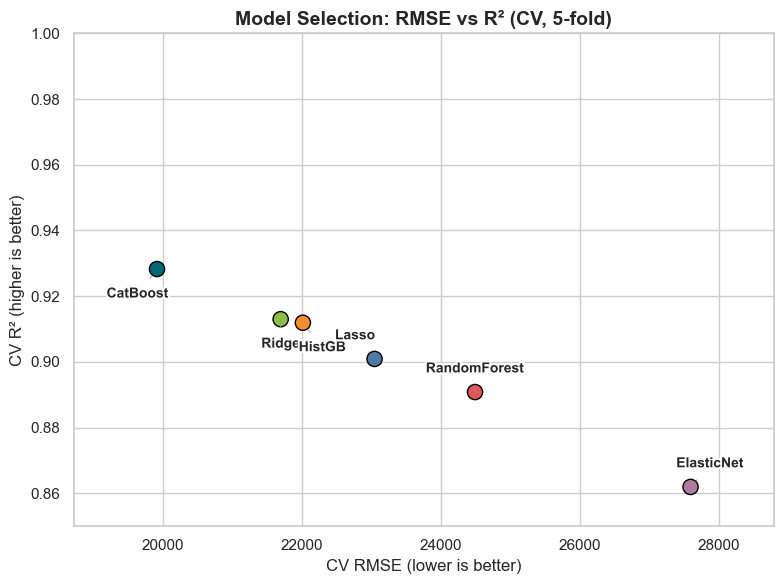

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

# Warwick-ish palette
warwick_palette = ["#006778","#8CBF3F","#F28E2B","#4E79A7","#E15759","#B07AA1"]

plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")

ax = sns.scatterplot(
    data=leaderboard,
    x="cv_rmse_mean", y="r2_cv",
    hue="model", palette=warwick_palette, s=120,
    edgecolor="black", linewidth=1, legend=False  # <-- no legend
)

# Offsets so labels don't sit on points (adjust if you like)
x_offsets = [-14, 0, 14, -14, 0, 14]  # cycles across points
y_mid = leaderboard["r2_cv"].median()

for i, row in leaderboard.reset_index(drop=True).iterrows():
    dx = x_offsets[i % len(x_offsets)]
    # put some labels above, some below to avoid collisions
    dy = 12 if row["r2_cv"] <= y_mid else -14
    va = "bottom" if dy > 0 else "top"

    ax.annotate(
        row["model"],
        xy=(row["cv_rmse_mean"], row["r2_cv"]),
        xytext=(dx, dy), textcoords="offset points",
        ha="center", va=va, fontsize=10, fontweight="bold",
        path_effects=[pe.withStroke(linewidth=3, foreground="white")],  # white outline
        arrowprops=dict(arrowstyle="-", color="0.6", lw=0.6, shrinkA=6, shrinkB=6)
    )

# Titles / axes
plt.title("Model Selection: RMSE vs R² (CV, 5-fold)", fontsize=14, weight="bold")
plt.xlabel("CV RMSE (lower is better)", fontsize=12)
plt.ylabel("CV R² (higher is better)", fontsize=12)
plt.xlim(leaderboard["cv_rmse_mean"].min()-1200, leaderboard["cv_rmse_mean"].max()+1200)
plt.ylim(0.85, 1.0)
plt.tight_layout()
plt.show()

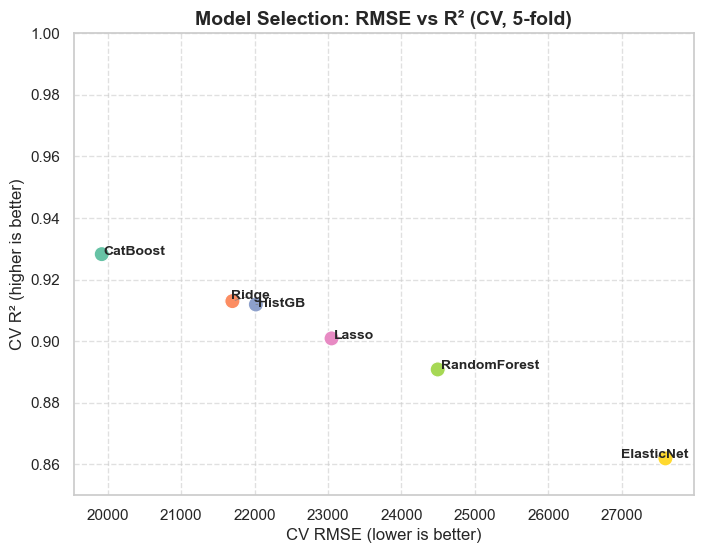

<class 'pandas.core.frame.DataFrame'> (2580, 82)
<class 'pandas.core.series.Series'> (2580,) 1    126000.0
2    139500.0
3    124900.0
4    114000.0
5    227000.0
Name: SalePrice, dtype: float64
Weighted CatBoost → RMSE: 19,847, R²: 0.936


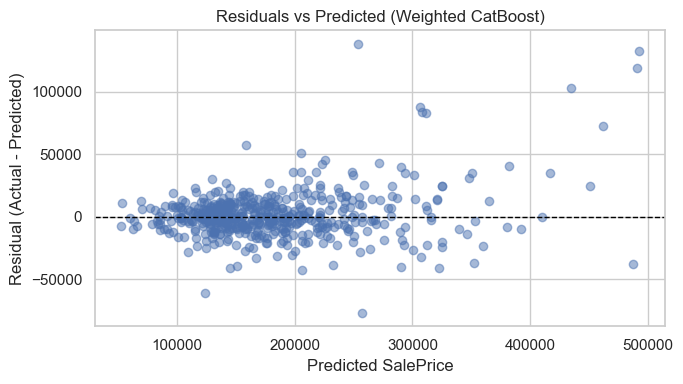

In [49]:
# 0) Restore clean data objects (avoid collisions)
Ames = Ames_original.copy()
y_target = Ames['SalePrice'].astype(float)
X_df = X_fe.copy()          # your engineered features dataframe

# 1) sanity checks
print(type(X_df), X_df.shape)
print(type(y_target), y_target.shape, y_target.head())

# 2) split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_target, test_size=0.20, random_state=42
)

# 3) price-proportional sample weights (tamed)
w_train = (y_train / y_train.mean()).clip(0.25, 4.0)

# 4) model (same preprocessing as before)
cb_weighted = make_catboost_pipe(
    X_df,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=5,
    iterations=1500,
    colsample_bylevel=0.8,
    verbose=0
)

# NOTE: model was trained on log1p target, so fit with log1p(y)
cb_weighted.fit(X_train, np.log1p(y_train), reg__sample_weight=w_train)

# 5) evaluate + residual plot
from sklearn.metrics import mean_squared_error, r2_score
y_pred_test = np.expm1(cb_weighted.predict(X_test))
residuals = y_test - y_pred_test

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))
r2   = float(r2_score(y_test, y_pred_test))
print(f"Weighted CatBoost → RMSE: {rmse:,.0f}, R²: {r2:.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Weighted CatBoost)")
plt.tight_layout()
plt.show()

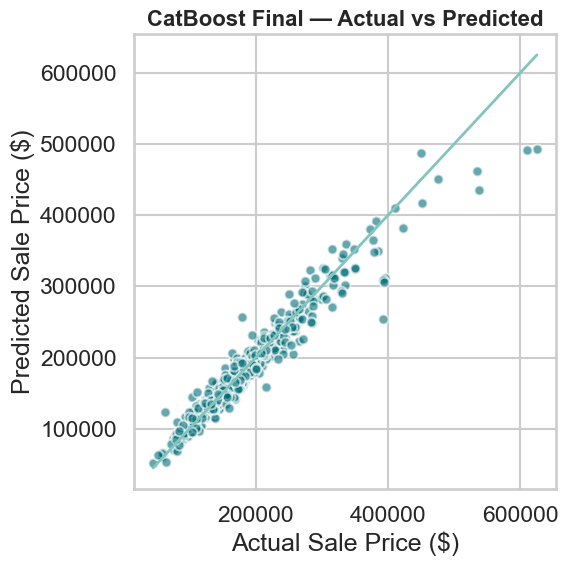

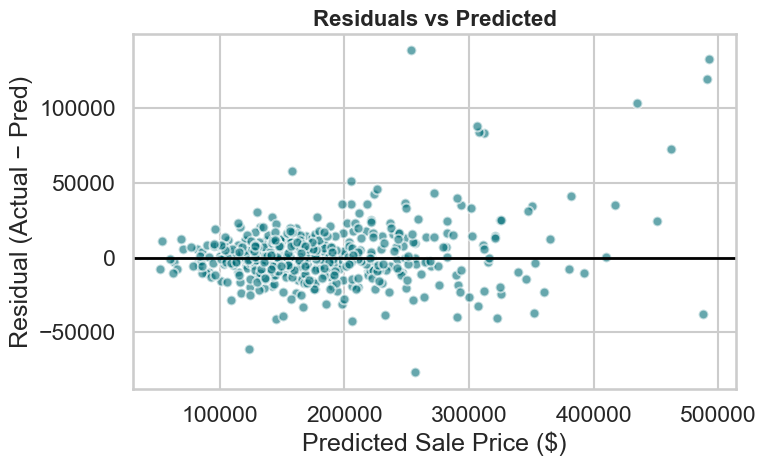

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Warwick slide theme colors (from your deck)
warwick_teal = "#006d77"
warwick_accent = "#83c5be"

sns.set_style("whitegrid")
sns.set_context("talk")

# --- 1. Parity Plot ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, color=warwick_teal, alpha=0.6, edgecolor="white", s=50)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color=warwick_accent, lw=2)
plt.title("CatBoost Final — Actual vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.tight_layout()
plt.show()

# --- 2. Residuals Plot ---
residuals = y_test - y_pred_test
plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, residuals, color=warwick_teal, alpha=0.6, edgecolor="white", s=50)
plt.axhline(0, color="black", lw=2)
plt.title("Residuals vs Predicted", fontsize=16, weight="bold")
plt.xlabel("Predicted Sale Price ($)")
plt.ylabel("Residual (Actual − Pred)")
plt.tight_layout()
plt.show()

In [54]:
pred = np.expm1(cb_final.predict(X_fe))
resid = y - pred
resid_pct = resid / y.clip(lower=1)  # % undervaluation

AttributeError: 'float' object has no attribute 'clip'

In [55]:
pred_log = cb_final.predict(X_fe)          # trained on log1p(y)
y_log = np.log1p(y)
resid_log = y_log - pred_log               # ~ log under/over-valuation
# Rank or threshold by resid_log instead of dollar residual